<a href="https://colab.research.google.com/github/NahuelCostaCortez/rapidae/blob/main/examples/rve_RUL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# RVE for Remaining Useful Life Estimation (RUL)

In [ ]:
# Install the library

!pip install rapidae

In [3]:
import numpy as np
from rapidae.data import load_CMAPSS, CMAPSS_preprocessor
from rapidae.models import RVE
from rapidae.pipelines import PreprocessPipeline, TrainingPipeline
from rapidae.evaluate import evaluate, cmapps_score, plot_latent_space
from sklearn.metrics import mean_squared_error

### Data

The data used is the Commercial Modular Aero-Propulsion System Simulation (C-MAPSS) dataset, a popular benchmark in the field of predictive maintenance. The C-MAPSS dataset comprises four subsets with run-to-failure trajectories of aircraft engines and the task is to predict the RUL of an engine, which is a regression task. Each data set is further divided into training and test subsets. Each time series is from a different engine i.e., the data can be considered to be from a fleet of engines of the same type.

Fix some parameters:
 - The selected subset
 - The specific sensors
 - The length of the window
 - The smoothing instensity
 - The max RUL

For more information you can check the paper: https://www.sciencedirect.com/science/article/pii/S2665963822000537

In [4]:
subset = 'FD004'
# sensors to work with: T30, T50, P30, PS30, phi
sensors = ['s_3', 's_4', 's_7', 's_10', 's_11', 's_12']
# windows length
sequence_length = 30
# smoothing intensity
alpha = 0.1
# max RUL
threshold = 125

The CMAPSS_preprocessor encapsulates a set of operations in order to prepare properly the data, like generating the RUL values, remove unused sensors, scaling, smoothing, etc.

In [75]:
data = load_CMAPSS(subset)

preprocess_pipeline = PreprocessPipeline(name='CMAPPS_preprocessing',
                                         preprocessor=CMAPSS_preprocessor)

data = preprocess_pipeline(train=data["x_train"],
                           test=data["x_test"],
                           y_test=data["y_test"],
                           sensors=sensors,
                           sequence_length=sequence_length,
                           alpha=alpha,
                           threshold=threshold)

2024-04-16 11:14:02 [INFO]: Selected preprocessor is a function.


### Model

Fix hyperparameters for the model.

In [6]:
timesteps = data["x_train"].shape[1]
input_dim = data["x_train"].shape[2]
intermediate_dim = 300
batch_size = 128
latent_dim = 2

Create the model. Since we are working with a predefined model the encoder is set by default with the parameters used in the paper.

If you want to experiment with hyperparameters you can instantiate the encoder by doing


```
from rapidae.models import Encoder

model = RVE(input_dim=(timesteps, input_dim),
            latent_dim=2,
            encoder=Encoder(input_dim=(timesteps, input_dim), latent_dim, parameter1, parameter2...))
```

Note that this model doesn´t have a decoder.

In [8]:
model = RVE(input_dim=(timesteps, input_dim),
            latent_dim=2,
            downstream_task='regression')

2024-04-16 10:38:36 [INFO]: Trying to set encoder and decoder from child class...
2024-04-16 10:38:36 [WARNING]: rve does not have a decoder.
2024-04-16 10:38:36 [INFO]: Encoder set from rve.
2024-04-16 10:38:36 [INFO]: Regressor set for the latent space.


### Training

Create and lauch the pipeline to train the model, in this example we have evaluation data so it can be fed to the pipeline.

In [10]:
epochs = 10000 # doesn't matter, we use early stopping
optimizer = 'adam'
pipeline = TrainingPipeline(name='RVE_RUL_CMAPSS',
                            model=model,
                            num_epochs=epochs,
                            batch_size=batch_size,
                            optimizer='adam',
                            learning_rate=0.01
                            )

trained_model = pipeline(x=data["x_train"], y=data["y_train"], x_val=data["x_val"], y_val=data["y_val"])

2024-04-16 10:38:52 [INFO]: +++ RVE_RUL_CMAPSS +++
2024-04-16 10:38:52 [INFO]: Creating folder in ./output_dir/RVE_RUL_CMAPSS_2024-04-16_10-38
2024-04-16 10:38:52 [INFO]: 
TRAINING STARTED
	Backend: tensorflow
	Eager mode: False
	Validation data available: True
	Callbacks set: ['EarlyStopping', 'ModelCheckpoint'] 



Epoch 1/10000


2024-04-16 10:38:56.481677: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8900



Epoch 1: val_loss improved from inf to 349.47842, saving model to ./output_dir/RVE_RUL_CMAPSS_2024-04-16_10-38/model.weights.h5
341/341 - 10s - 30ms/step - kl_loss: 35.8842 - loss: 1077.4121 - reg_loss: 1038.9094 - val_kl_loss: 16.8246 - val_loss: 349.4784 - val_reg_loss: 330.2044
Epoch 2/10000

Epoch 2: val_loss improved from 349.47842 to 311.55832, saving model to ./output_dir/RVE_RUL_CMAPSS_2024-04-16_10-38/model.weights.h5
341/341 - 5s - 14ms/step - kl_loss: 13.9063 - loss: 234.8944 - reg_loss: 220.4519 - val_kl_loss: 11.8503 - val_loss: 311.5583 - val_reg_loss: 297.3063
Epoch 3/10000

Epoch 3: val_loss did not improve from 311.55832
341/341 - 5s - 14ms/step - kl_loss: 11.7492 - loss: 211.7280 - reg_loss: 199.5591 - val_kl_loss: 9.9492 - val_loss: 326.6198 - val_reg_loss: 313.5473
Epoch 4/10000

Epoch 4: val_loss improved from 311.55832 to 299.97940, saving model to ./output_dir/RVE_RUL_CMAPSS_2024-04-16_10-38/model.weights.h5
341/341 - 5s - 14ms/step - kl_loss: 11.1396 - loss: 20

2024-04-16 10:40:04 [INFO]: Restoring best model
2024-04-16 10:40:04 [INFO]: Best model restored


### Evaluation step

Let's now make evaluate the model over the test set. The selected metrics to evaluate this are the mean square error and the CMAPSS score.
Here we can see the difference between using the evaluate method with a metric imported from the Scikit-Learn library and a custom one.

In [78]:
outputs = trained_model.predict(data["x_test"])

# model only predicts RULs lower than threshold
y_test = data["y_test"].clip(upper=threshold)

print("RMSE:", mean_squared_error(np.expand_dims(y_test, axis=-1), outputs['reg'], squared=False))
evaluate(y_true=np.expand_dims(y_test, axis=-1),
         y_hat=outputs['reg'], sel_metric=cmapps_score.CMAPSS_Score())

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


2024-04-16 11:14:46 [INFO]: Using Rapidae custom metric...


RMSE: 16.803136852537683
test set results: [
	 CMAPSS_Score: 1785.535346367099 
]


array(1785.53534637)

  16/1361 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step  

1361/1361 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


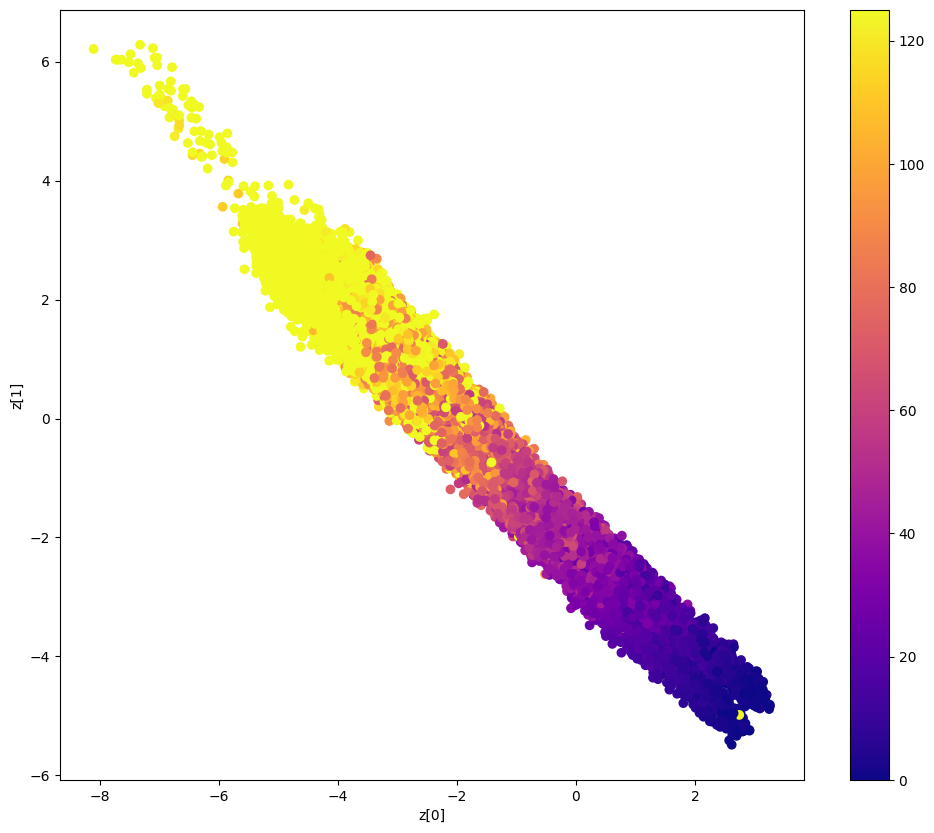

In [79]:
outputs_train = trained_model.predict(data["x_train"])
plot_latent_space(outputs_train['z'], data["y_train"])

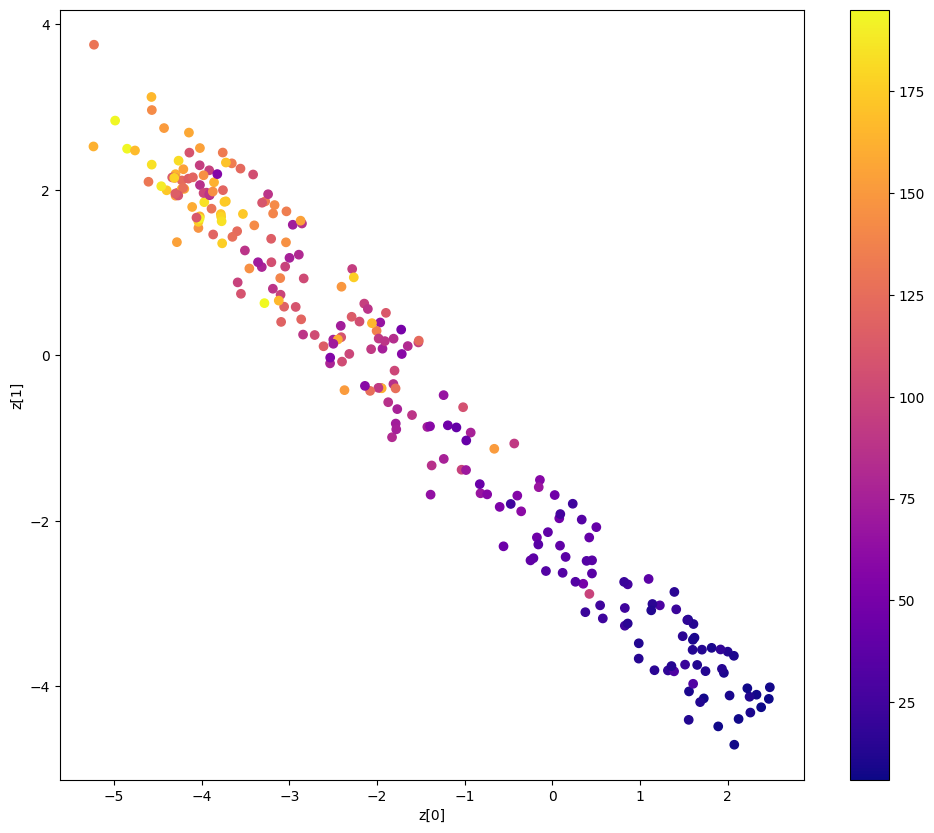

In [81]:
plot_latent_space(outputs['z'], data["y_test"])